# Predicting life expectancy from World Bank data

### By Micaela McCall

The World Bank reports a massive amount of [Environment, Social, And Governance (ESG)](https://datacatalog.worldbank.org/dataset/environment-social-and-governance-data) data  for numerous countries and geographical regions. The World Bank's [sustainable development goals](https://datatopics.worldbank.org/world-development-indicators/wdi-and-the-sustainable-development-goals.html) aim to improve these measures in order to improve the well-being of populations.

For me, it is fascinating that this myriad of measures can have such a significant impact on the well-being of populations. How does one measure well-being? One rough proxy is lifespan. Obviously, factors such as clean water and good healthcare can affect lifespan; but we are discovering that even factors such as [intergenerational stress](https://epigeneticsandchromatin.biomedcentral.com/articles/10.1186/s13072-017-0145-1) can have an effect on lifespan. 

In this project, I explored the relationship between sustainable development indicators reported by the World Bank and life expectancy. I perform mutiliniear regression and create a model to predict country-wide mean life expectancy using variables reported in the ESG dataset.

## Setup
Install/attach required packages

In [ ]:
p<-.libPaths() #where your packages are installed 
`%notin%` <- Negate(`%in%`)

pkgs<-c('dplyr', 'tidyr', 'ggplot2', 'corrplot', 'psych', 'plotly') # packages needed for this project

for (i in 1:length(pkgs)){
  pkg<-pkgs[[i]]
  if (pkg %notin% rownames(installed.packages())){
    install.packages(pkg, p)
  }
  if (pkg %in% rownames(installed.packages()) & pkg %notin% loadedNamespaces()){
    library(pkg, character.only = T)
    print(paste("Attaching package:", pkg))
  }
  if (pkg %notin% rownames(installed.packages())){
    print(paste("Error installing ", pkg, ". Check Warnings."))
  }
}

# Load the data from the data folder

In [ ]:
header<- read.csv("../data/ESGData.csv", nrows = 1) # load the header separately
wb <- read.csv("../data/ESGData.csv", header= FALSE, skip = 3084) # load the data itself
colnames(wb)<-colnames(header) # assign column names
rm(header) #clean up by removing extra assignment

print(paste("The WB dataframe has", dim(wb)[1], "rows and", dim(wb)[2], "columns"))
head(wb)

In this dataframe, the columns represent a measure of an Indicator from the 'Indicator.Name' column, every year from 1960 onwards. 
## The code below tidies and averages indicator values accross years.
First, I only want to look at current years. Also, since there are many missing values in the data, I decided to average measurements per country over 2013-2017. 



In [ ]:
wb_tidy<-wb%>% 
  select(Country.Name, Indicator.Name, X2013, X2014, X2015, X2016, X2017)%>% # select recent years
  droplevels()%>% # reset index
  gather(Year, Value, -Country.Name, -Indicator.Name)%>%    # make 1 row for each year for each indicator
  group_by(Country.Name, Indicator.Name)%>%  # group by country and indicator and average the value over all years listed 
  summarise(Avg.Value=mean(Value, na.rm = TRUE))%>%
  spread(Indicator.Name, Avg.Value) # make each row one country and each column a different indicator

# List all the indicators
print('INDICATOR NAMES:')
colnames(wb_tidy)

## The code below creates a new data frame with the data selected for regression analysis.

I took a look at how many NAs were in each variable and selected some variables with minimal missing values to use for further analysis. 

In [ ]:
wb_select <- wb_tidy%>%
  select(c(Country.Name,  #select columns
           `Renewable electricity output (% of total electricity output)`,
           `Access to electricity (% of population)`, 
           `Renewable energy consumption (% of total final energy consumption)`,
           `Terrestrial and marine protected areas (% of total territorial area)`, 
           `Agricultural land (% of land area)`,  
           `Individuals using the Internet (% of population)`,
           `CO2 emissions (metric tons per capita)`, 
           `GDP growth (annual %)`,
           `Political Stability and Absence of Violence/Terrorism: Estimate`,
           `Rule of Law: Estimate`,
           `Government Effectiveness: Estimate`,
           `PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)`,
           `Proportion of seats held by women in national parliaments (%)`,
           `Access to clean fuels and technologies for cooking (% of population)`,
           `Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)`,
           `Unemployment, total (% of total labor force) (modeled ILO estimate)`,
           `School enrollment, primary (% gross)`,
           `Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)`,
           `Adjusted savings: natural resources depletion (% of GNI)`,
           `Prevalence of undernourishment (% of population)`,
           `Life expectancy at birth, total (years)`))%>%
  na.omit()%>%  # remove NAs
  ungroup()

## Next, we'll visually explore the data and check for skewness. 

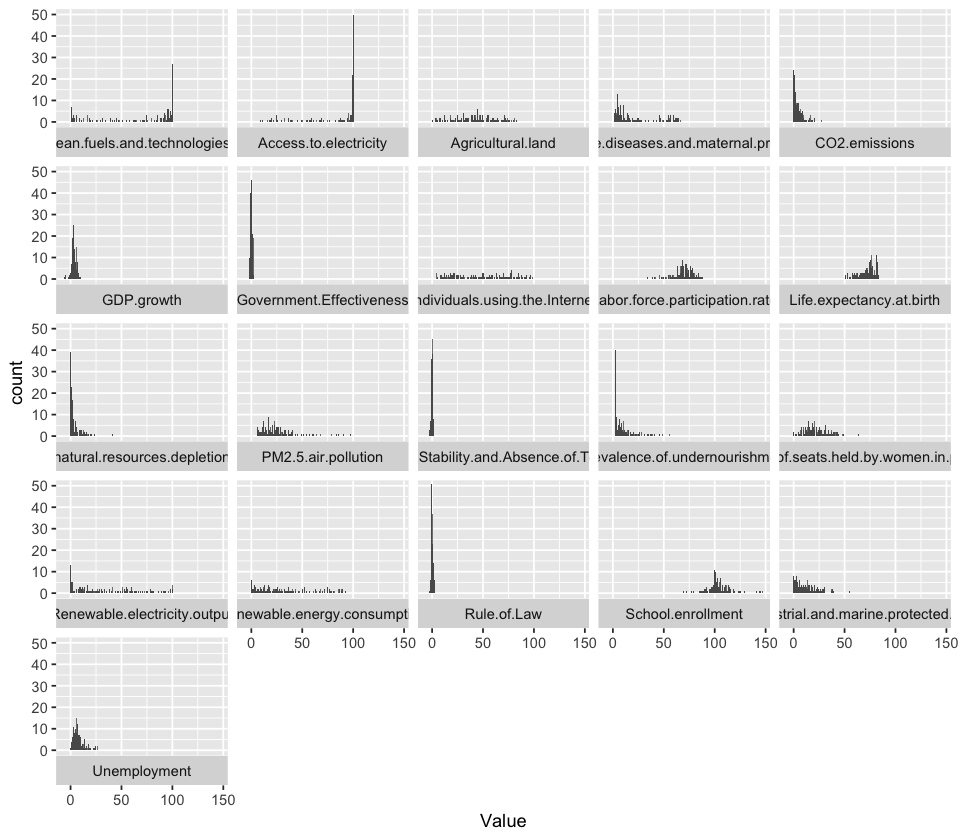

In [22]:
library(repr)
options(repr.plot.width=8) #resize plot
wb_select<-read.csv("../data/wb_tidy.csv", row.names = 1)
library(ggplot2)

check_skew<-gather(wb_select, Measure, Value, -Country)  # reshape the dataframe for plotting

ggplot(check_skew, aes(Value))+ # make histograms
  geom_histogram(bins = 200)+
  facet_wrap(~Measure,strip.position = "bottom")+
  coord_cartesian(ylim = c(0,50))


rm(check_skew) #remove this dataframe so it doesnt clutter our environment

Most of these variables are right skewed, so they could be transformed with a natural log transformation
## Below, some columns are log-transformed

In [ ]:
library(dplyr)
wb_log<-wb_select%>%
  mutate_at(vars(Renewable.electricity.output, 
                 Renewable.energy.consumption, 
                 Terrestrial.and.marine.protected.areas, 
                 CO2.emissions, 
                 PM2.5.air.pollution, 
                 Unemployment, 
                 Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions, 
                 natural.resources.depletion,
                 Prevalence.of.undernourishment), 
            ~log1p(1+.))%>% # log after adding 1 to make all data positive
  mutate_at(vars(Access.to.electricity, 
                 Access.to.clean.fuels.and.technologies.for.cooking), 
            ~log1p(101-.)) # left skewed variable transformed after subtracted from 110 to turn it into a left skew

## Next, the data is re-scaled between 0 and 1 because regression performs better on data that is uniformly scaled

In [ ]:
wb_scaled<-wb_log%>%
  mutate_at(c('Renewable.electricity.output',
               'Access.to.electricity', 
               'Renewable.energy.consumption',
               'Terrestrial.and.marine.protected.areas', 
               'Agricultural.land',  
               'Individuals.using.the.Internet',
               'CO2.emissions', 
               'GDP.growth',
               'Political.Stability.and.Absence.of.Terrorism',
               'Rule.of.Law',
               'Government.Effectiveness',
               'PM2.5.air.pollution',
               'Proportion.of.seats.held.by.women.in.parliaments',
               'Access.to.clean.fuels.and.technologies.for.cooking',
               'Labor.force.participation.rate',
               'Unemployment',
               'School.enrollment',
               'Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions',
               'natural.resources.depletion',
               'Prevalence.of.undernourishment',
               'Life.expectancy.at.birth'), ~(.-min(.))/(max(.)-min(.)))

## Here we visualize the transformed data to make sure the transformation worked as anticipated

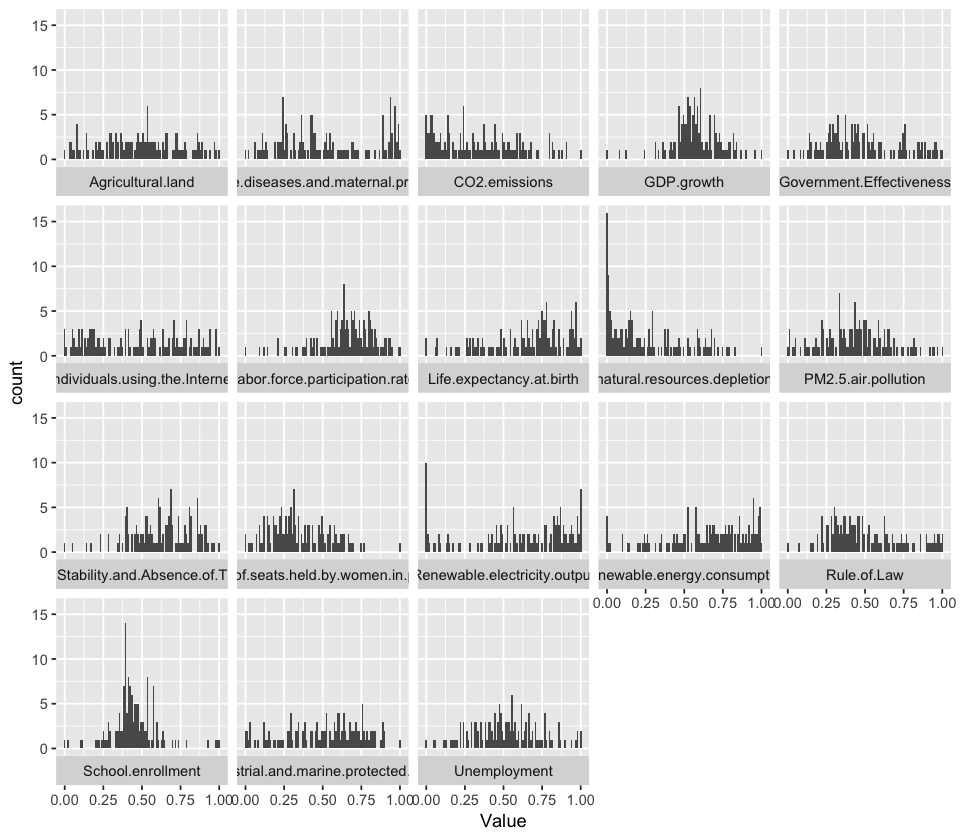

In [23]:
options(repr.plot.width=8) #resize plot

check_scaling<-wb_scaled%>%
  select(-c(Access.to.clean.fuels.and.technologies.for.cooking, Access.to.electricity, Prevalence.of.undernourishment))%>%
  gather(Measure, Value, -Country) # re-shape for plotting
check_scaling$Measure<-as.factor(check_scaling$Measure) 

ggplot(check_scaling, aes(Value))+ # make histograms
  geom_histogram(bins = 100)+
  facet_wrap(~Measure,strip.position = "bottom")
rm(check_scaling) #remove this dataframe so it doesnt clutter our environment

Now the data looks way more normally distributed 
## Start exploring the data by visualizing the correlations between each variable

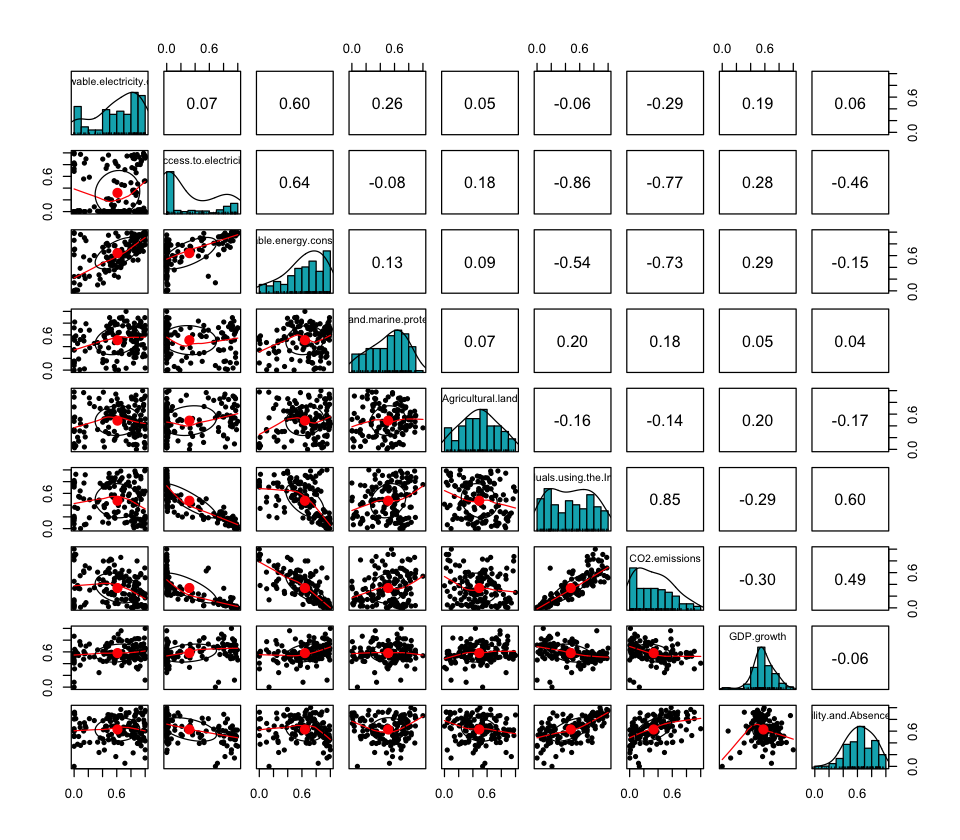

In [24]:
options(repr.plot.width=8) #resize plot
wb_transformed<-read.csv("../data/wb_transformed.csv",row.names = 1)
library(psych)
pairs.panels(wb_transformed[,2:10],
             method = "pearson",
             hist.col = "#00AFBB")

## Here is another way to visualize correlations that I like to use

In [ ]:
library(corrplot)
corrplot(cor(wb_transformed[2:10]),order="hclust",tl.col="black",tl.cex=.62)

## Because I am interested in the predicting life expectancy, I want to visualize the relationship between life expectancy and each of the other variables 

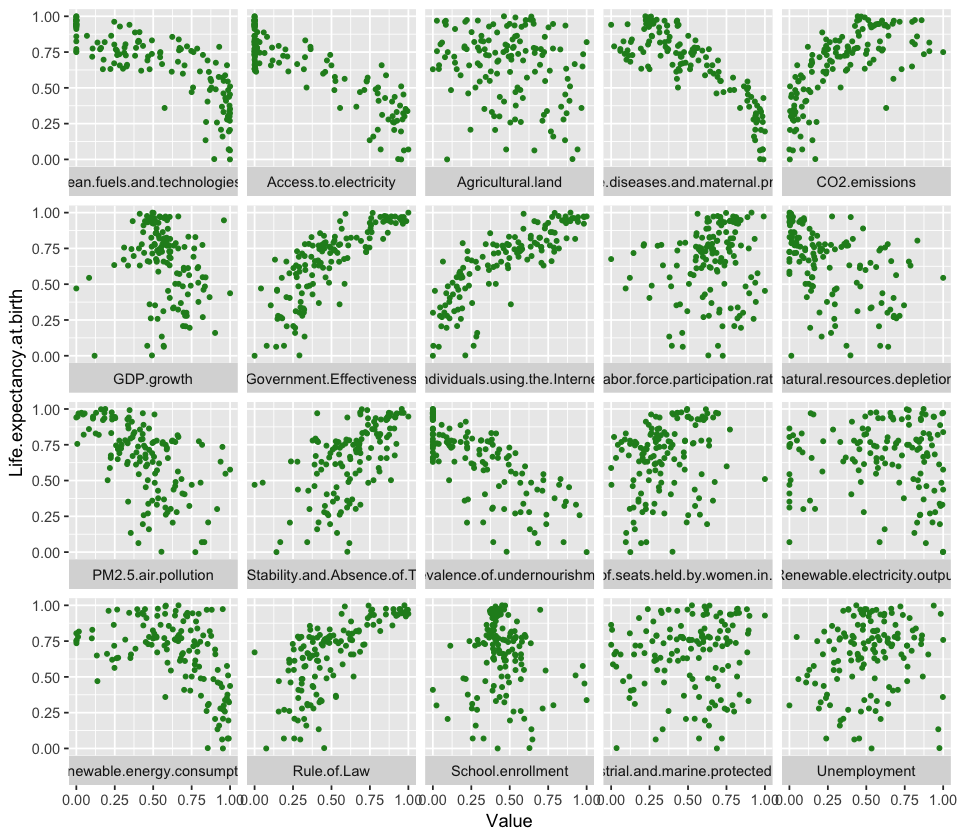

In [25]:
# re-shape the data for plotting
wb_long<-gather(wb_transformed, Measure, Value, -Country, -Life.expectancy.at.birth)
wb_long$Measure<-as.factor(wb_long$Measure)

options(repr.plot.width=8) #resize plot
ggplot(wb_long, aes(x=Value,y=Life.expectancy.at.birth))+
  geom_point(size=1,color='forestgreen')+
  facet_wrap(~Measure,strip.position = "bottom")


Some of these variable clearly have a nonlinear relationship with life expectancy. Specifically, for CO2.emissions, Rule.of.law, Indiviuals.using.the.internet, and Government.effectiveness, their relationship with life expectancy follows a square root function. 

Also, for Access.to.electricity, Renewable.energy.consumption, Access.to.clean.fuels.and.technologies.for.cooking, and Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions, they follow a negative square root relationship. 

These relationships can be added into the linear model. 


## Now it's time to make the multilinear model. 

I start by constructing a full model with all the variables

In [ ]:
fullmodel<-lm(Life.expectancy.at.birth ~ 
                Renewable.electricity.output + 
                I(sqrt(-(Access.to.electricity)+1)) + # square root of the negative plus 1 (move to positive side of x axis)
                I(sqrt(-(Renewable.energy.consumption)+1)) + 
                Terrestrial.and.marine.protected.areas +
                Agricultural.land +
                I(sqrt(Individuals.using.the.Internet)) +
                I(sqrt(CO2.emissions)) +
                GDP.growth +
                Political.Stability.and.Absence.of.Terrorism +
                I(sqrt(Rule.of.Law)) +
                I(sqrt(Government.Effectiveness)) +
                PM2.5.air.pollution +
                Proportion.of.seats.held.by.women.in.parliaments +
                I(sqrt(-(Access.to.clean.fuels.and.technologies.for.cooking)+1)) +
                Labor.force.participation.rate +
                Unemployment +
                School.enrollment +
                I(sqrt(-(Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions)+1)) +
                natural.resources.depletion +
                Prevalence.of.undernourishment, data=wb_transformed)

Then, we use backward elimination to select the variables that are predictive of life expectancy. 

Backward elimination uses the model selection strategy of minimizing AIC. It measures how much information about the data is lost in a model and thus assesses the trade off between model complexity and generalizability (overfitting v underfitting).  

During each iteration, backward elimination drops the variable that gives the highest AIC until there is no significant drop in AIC. The model that yields the lowest AIC is retained in 'model'.

In [ ]:
model <- step(fullmodel,direction="backward",trace=10)

## Backward elimination shows us the combination of variables that can be used to predict the life expectancy. 

Here, we inspect the model closer.

In [ ]:
summary(model)

This output shows is that the model of life expectancy as a function of the above variables was significant (F(11,126) = 99.71, p < 0.01). In addition, R-squared  tells us that 89% of variance in life expectancy is accounted for by the variables in this model. This is quite high considering the messy/complicated system of country-wide social and economic factors. This seems to be a good model. 

FYI I ran a similar model without square root relationship accounted for, and including the square roots improved the model (F(10,127) = 79.1, p < 0.01, R-squared for 0.86). 

# However, this isn't the end of the story. We need to make sure that the assumptions of linear models are satisfied in order to be sure that the model is meaningful. 

## One assumption to inspect is absence of collinearity.
If predictors are highly correlated (collinearity) the statistical significance of the model is undermined. We can look at this by looking at the variance inflation factor (VIF) of each predictor. VIF measures how easily the predictor is predicted from a linear regression using the other predictors. Any predictors with a VIF above 4 should be removed from the model.

In [ ]:
library(car)
vifs<-dplyr::bind_cols(as.data.frame(names(vif(model))), as.data.frame(unname(vif(model))));vifs

Since several of these variables have a large VIF, some should be removed. 
While there is no rule in terms of what is a good VIF threshold, the following code removes the variable with the largest VIF and re-builds the model until no variables have  VIF above 10. 

In [ ]:
while(any(vifs$`unname(vif(model))`>10)){  #while any VIFS are greater than 4
  vifs<-filter(vifs,  `unname(vif(model))`!=max(`unname(vif(model))`))  #take out the variable with the largest VIF
  formula<-paste("Life.expectancy.at.birth ~", paste(vifs$`names(vif(model))`, collapse = ' + '), sep=' ')  #create a new formula without that variables
  newmodel<-lm(formula, data = wb_transformed) #create a new model
  vifs=bind_cols(as.data.frame(names(vif(model))), as.data.frame(unname(vif(model))))  #create a new dataframe with the VIFs from the new model
}
finalmodel<-step(newmodel,direction="backward",trace=10)

This new model satisfies the assumption of no collinearity.

## Another assumption of that of homoskedasticity, 
which means that te residuals of the model have a similar amount of deviation from predicted values. To assess this assumption, we can look at a residual plot. This plot should look like a blob; if it doesn't, for instance if higher values have higher residuals, the variance would not be homoskedastic. 


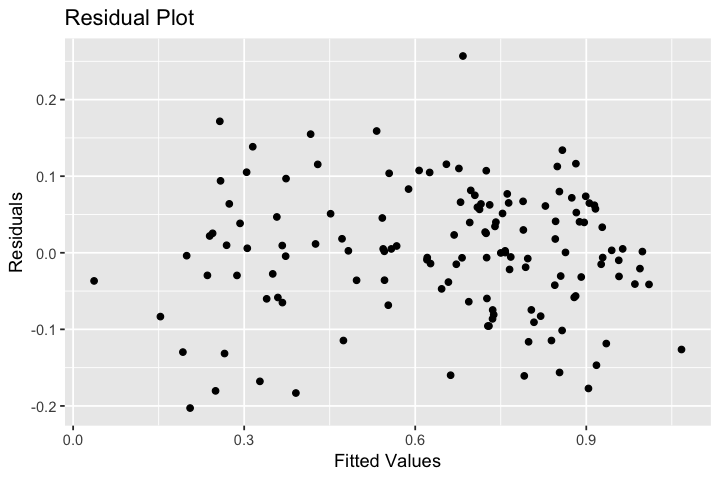

In [27]:
options(repr.plot.width=6, repr.plot.height=4) #resize plot
resid <- bind_cols(as.data.frame(fitted(finalmodel)), as.data.frame(residuals(finalmodel))) 

p1 <- ggplot(resid,aes(x= fitted(finalmodel), y=residuals(finalmodel))) + geom_point() + labs(title='Residual Plot', x='Fitted Values', y='Residuals');p1
# with this plot, we are look for absence of a pattern

## Last, there is the assumption of the normality of residuals. 
The residuals should follow a normal distribution. If they don't, this indicates that the model is not fit optimally. 

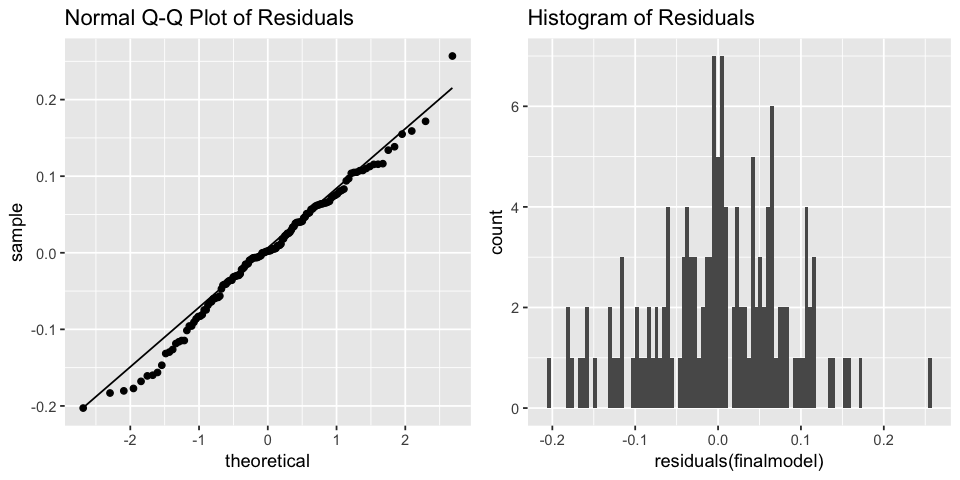

In [28]:
options(repr.plot.width=8, repr.plot.height=4) #resize plot
p2 <- ggplot(resid, aes(residuals(finalmodel))) + geom_histogram(bins=100) + labs(title = 'Histogram of Residuals')
# with the histogram, we're looking for a normal distribution
p3 <- ggplot(resid, aes(sample=residuals(finalmodel))) + geom_qq() + geom_qq_line() + labs(title = "Normal Q-Q Plot of Residuals") 
# with the qqnorm plot, we are looking for a straight line

gridExtra::grid.arrange(p3, p2, nrow=1)

# Summary of the final model and plot:

In [37]:
summary(finalmodel)


Call:
lm(formula = Life.expectancy.at.birth ~ Renewable.electricity.output + 
    Agricultural.land + I(sqrt(CO2.emissions)) + I(sqrt(Government.Effectiveness)) + 
    Proportion.of.seats.held.by.women.in.parliaments + I(sqrt(-(Access.to.clean.fuels.and.technologies.for.cooking) + 
    1)) + Unemployment + I(sqrt(-(Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions) + 
    1)), data = wb_transformed)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.202775 -0.045945  0.002207  0.058953  0.256929 

Coefficients:
                                                                                                    Estimate
(Intercept)                                                                                          0.09309
Renewable.electricity.output                                                                        -0.05392
Agricultural.land                                                                                   -0.078


## Here's a plot of the variables included in the model, the predictors are scaled whereas the outcome of life expectancy is the original value. 


In [33]:
library(plotly)
wb_outcome<-read.csv("../data/wb_tidy.csv", row.names = 1)%>%   # store outcome
  select(Country, Life.expectancy.at.birth)

# dataframe with scaled predictors and original outcome
for_plot<-left_join(wb_transformed, wb_outcome, by='Country')%>%
  select(Country, 
         Renewable.electricity.output, 
         Agricultural.land, 
         CO2.emissions, 
         Government.Effectiveness, 
         Proportion.of.seats.held.by.women.in.parliaments, 
         Access.to.clean.fuels.and.technologies.for.cooking,
         Unemployment, 
         Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions,
         Life.expectancy.at.birth.y)

# Pretty column names for graph
colnames(for_plot) <- c('Country',
                        'Renewable energy consumption (% of total)',
                        'Agricultural land (% of land area)', 
                        'CO2 emissions (metric tons per capita)',
                        'Government Effectiveness: Estimate',
                        'Seats held by women in national parliaments (%)',
                        'Access to clean fuels and technologies for cooking (%)',
                        'Unemployment (% of total labor force)',
                        'CoD by communicable diseases, maternal, and prenatal cond (%)',
                        'Life expectancy at birth, total (years)')

# Re-shape
for_plot<-gather(for_plot, Measure, Value, -Country, -`Life expectancy at birth, total (years)`)
for_plot$Measure<-as.factor(for_plot$Measure)

p <-ggplotly(ggplot(for_plot, 
                    aes(x = Value, 
                        y = `Life expectancy at birth, total (years)`, 
                        group = Measure, 
                        text = paste("Country:",Country,'<br>', Measure, ':', Value, '<br>Life Expectancy:', `Life expectancy at birth, total (years)`, ' years')))+
               geom_point(aes(color=Measure))+
               geom_smooth(aes(color=Measure), method=lm,size=.7,se=F)+
               labs(title= "Normalized predictors of life expectancy", x="Normalized Measure Value", y="Life expectancy at birth, total (years)")+
               theme_minimal(), tooltip = "text")%>%
  layout(legend = list(x=1,y=1,font=list(size=10)))

p

HTML widgets cannot be represented in plain text (need html)

The final model significantly predicts life expectancy (F(8,120) = 130.7, p < 0.01) and accounts for 89% of variance in life expectancy.

This output also tells at that there are main effects on life expectancy of renewable electricity output (beta=-0.05, p=0.05), agricultural land (beta=0.08, p=0.02), CO2 emissions (beta=-0.22, p=<0.01), government effectiveness score (beta=0.41, p<0.01), proportion of seats held by women (beta=0.011, p=0.02), unemployment rate (beta=-0.011, p<0.01), and cause of death by communicabel diseases, and maternal and prenatal nutrition conditions (beta=0.55, p<0.01).

Some of these coefficients relate the predictor to life expectancy in a linear manner, while others modify the relationship between life expectancy and the square root of the predictor or the square root of the negative of the predictor. 

## It is important to keep in mind that several transformations have been done to this data before running the linear model. Looking back at the correlations in the original data can therefore be informative.

In [31]:
eval<-read.csv("../data/wb_tidy.csv", row.names = 1)%>%  #re-import tidy
  select(Country,                # select columns that were selected through linear modelling
         Renewable.electricity.output, 
         Agricultural.land, 
         CO2.emissions, 
         Government.Effectiveness, 
         Proportion.of.seats.held.by.women.in.parliaments, 
         Access.to.clean.fuels.and.technologies.for.cooking,
         Unemployment, 
         Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions,
         Life.expectancy.at.birth)

#print correlations between life expectancy and each predictor in original form, and compare to the coefficients

for (i in 2:length(finalmodel$coefficients)){
  var<-colnames(eval)[i]
  col<-select(eval, var)
  print(paste("Correlation between", var, "and life expectancy  :  ", cor(col, eval$Life.expectancy.at.birth) ))
  print(paste("Coefficient of", names(finalmodel$coefficients)[i], "  :  ", unname(finalmodel$coefficients)[i]))
}

[1] "Correlation between Renewable.electricity.output and life expectancy  :   -0.15566049402084"
[1] "Coefficient of Renewable.electricity.output   :   -0.0539242582484038"
[1] "Correlation between Agricultural.land and life expectancy  :   -0.242107651731132"
[1] "Coefficient of Agricultural.land   :   -0.0785069492907549"
[1] "Correlation between CO2.emissions and life expectancy  :   0.519339183005131"
[1] "Coefficient of I(sqrt(CO2.emissions))   :   -0.219891807349506"
[1] "Correlation between Government.Effectiveness and life expectancy  :   0.787763732356985"
[1] "Coefficient of I(sqrt(Government.Effectiveness))   :   0.406672313008985"
[1] "Correlation between Proportion.of.seats.held.by.women.in.parliaments and life expectancy  :   0.243280896253561"
[1] "Coefficient of Proportion.of.seats.held.by.women.in.parliaments   :   0.105793083175096"
[1] "Correlation between Access.to.clean.fuels.and.technologies.for.cooking and life expectancy  :   0.826387313091181"
[1] "Coefficient